In [1]:
import numpy as np
import torch
import json
from munch import Munch
import itertools
from collections import defaultdict
import random
import copy
import pickle
import matplotlib.pyplot as plt
import importlib
import time

import apt_helper as ahlp
import apt_cst_aggregate as cagg
import mv_Viterbi as mv

In [2]:
import importlib
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [3]:
names = ['apt','bob','sally']
mu_list = [.8,.9,.9]
apt_hmm, bob_hmm, sally_hmm = ahlp.process_load(names, delay = mu_list)
user_list = [bob_hmm, sally_hmm]

In [4]:
cst_names = ['know_sally_exists','have_sally_credential', 'learn_where_data_stored', 'have_data_on_ds', 'have_data_on_hi', 'have_data_on_he']
cst_names = [names + '_TRUE' for names in cst_names]
cst_list=  []
for name in cst_names:
    module = importlib.import_module(name)
    
    curr_cst =  Munch(name = module.name, \
                      aux_size = module.aug_size, \
                      update_fun = module.update_fun, \
                      init_fun = module.init_fun, \
                      forbidden_emissions = module.forbidden_emissions, \
                      forbidden_transitions = module.forbidden_transitions, \
                      knowledge_state = module.knowledge_state, \
                      cst_fun = module.cst_fun)
    if hasattr(module, 'dependency'):
        curr_cst.dependency = module.dependency
    cst_list.append(curr_cst)

sat = len(cst_list) * (True,)

In [5]:
#Check if correctly loaded. probabilities should sum to 1.
for usr in user_list:
    usr_params = ahlp.hmm2numpy(usr)
    print(f'initprob:{usr_params[0].sum()}  tprob: {usr_params[1].sum(axis = 1)}  eprob: {usr_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
apt_params, ix_list = ahlp.hmm2numpy(apt_hmm, return_ix = True)
print(f'initprob:{apt_params[0].sum()}  tprob: {apt_params[1].sum(axis = 1)}  eprob: {apt_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Sanity Check that base Viterbi works. Pure Emissions

In [7]:
len(apt_hmm.eprob.keys())

25

In [8]:
pure_hidden, pure_emission = ahlp.simulation_apt(apt_hmm, ix_list = None, emit_inhom = False)

In [9]:
opt_state =  mv.mv_Viterbi(obs = pure_emission, hmm = apt_hmm)
for t in range(len(opt_state)):
    if opt_state[t] != pure_hidden[t]:
        print(f'mismatch at time {t} out of {len(opt_state) -1}') #no rule enforcing that that must end on POST

mismatch at time 34 out of 44
mismatch at time 35 out of 44
mismatch at time 36 out of 44
mismatch at time 37 out of 44
mismatch at time 38 out of 44
mismatch at time 39 out of 44
mismatch at time 40 out of 44
mismatch at time 41 out of 44
mismatch at time 42 out of 44
mismatch at time 43 out of 44


In [10]:
pure_hidden[26]

'WAIT_EX'

In [11]:
opt_state[26]

'WAIT_EX'

### Check that Numpy Implementation Gives Same Answer

In [12]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [13]:
emit_weights = ahlp.compute_emitweights(pure_emission,apt_hmm, time_hom = True)
hmm_params = [apt_params[1], apt_params[0]]
opt_list = mv.Viterbi_numpy(hmm_params, emit_weights)
state_ix, _ = ix_list
state_ix = {v:k for k,v in state_ix.items()}
numpy_list = [state_ix[i] for i in opt_list]

In [14]:
num_correct = 0
for t in range(len(numpy_list)):
    if numpy_list[t] == opt_state[t]:
        num_correct += 1
print(f'proportion correct: {num_correct/len(numpy_list)}')

proportion correct: 1.0


In [37]:
len(apt_hmm.eprob.keys())

25

## Check Numpy with Dummy Constraint Gives Same Answer

In [38]:
cst_names = ['dummy_constraint']
dummy_cst_list =  []
for name in cst_names:
    module = importlib.import_module(name)
    
    curr_cst =  Munch(name = module.name, \
                      aux_size = module.aug_size, \
                      update_fun = module.update_fun, \
                      init_fun = module.init_fun, \
                      forbidden_emissions = module.forbidden_emissions, \
                      forbidden_transitions = module.forbidden_transitions, \
                      knowledge_state = module.knowledge_state, \
                      cst_fun = module.cst_fun)
    if hasattr(module, 'dependency'):
        curr_cst.dependency = module.dependency
    dummy_cst_list.append(curr_cst)

# cst_list = cst_list
dummy_sat = len(dummy_cst_list) * (True,)

apt_params, cst_params = ahlp.arrayConvert(apt_hmm, dummy_cst_list[0], sat = (True,))
opt_cst_list = mv.mv_Viterbi_numpy(apt_params, emit_weights, cst_params)
numpy_cst_list = [state_ix[state[0]] for state in opt_cst_list]

In [39]:
num_correct = 0
for t in range(len(numpy_list)):
    if numpy_list[t] == numpy_cst_list[t]:
        num_correct += 1
print(f'proportion correct: {num_correct/len(numpy_list)}')

proportion correct: 1.0


In [40]:
len(apt_hmm.eprob.keys())

25

# Sanity Check. Torch Version with Dummy Constraint also Gives Same Answer

In [41]:
opt_torch_list, _ = ahlp.Viterbi_torch_list(apt_hmm, dummy_cst_list, pure_emission, dummy_sat, time_hom = True, device = 'cuda:0')
num_correct = [torch == numpy for torch, numpy in zip(opt_torch_list,numpy_cst_list)]
print(f'proportion correct: {len(num_correct)/len(num_correct)}')

proportion correct: 1.0


# Sanity Check. Noiseless Tiered APT Equivalent to Original

In [16]:
tier_apt = ahlp.create_tiered_apt(apt_hmm)
apt_params = ahlp.hmm2numpy(tier_apt)
print(f'initprob:{apt_params[0].sum()}  tprob: {apt_params[1].sum(axis = 1)}  eprob: {apt_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


In [17]:
tier_apt.states

[('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('EX', ('V', 'access/bob')),
 ('EX', ('V', 'access/sally')),
 ('EX', ('S', 'postfix/local')),
 ('EX', ('HI', 'img/post')),
 ('EX', ('HE', 'img/post')),
 ('EX', ('DS', 'syslog/nano')),
 ('DI', ('S', 'postfix/local')),
 ('DI', ('HI', 'usr/query')),
 ('DI', ('HI', 'img/query')),
 ('DI', ('HE', 'img/query')),
 ('DI', ('DS', 'syslog/ls')),
 ('CA', ('HI', 'usr/query')),
 ('COL', ('HI', 'img/post')),
 ('COL', ('HE', 'img/post')),
 ('COL', ('DS', 'syslog/nano')),
 ('EXF', ('HE', 'img/query')),
 ('POST', None),
 ('WAIT_EXF', None),
 ('WAIT_CA', None),
 ('WAIT_EX', None),
 ('WAIT_DI', None),
 ('WAIT_IA', None),
 ('WAIT_COL', None)]

In [44]:
opt_state_tier =  mv.mv_Viterbi(obs = pure_emission, hmm = tier_apt)
num_correct = 0
for t in range(len(opt_state)):
    # if opt_state[t] != opt_state_tier[t][0]:
    #     print(f'mismatch at time {t} out of {len(opt_state) -1}') #no rule enforcing that that must end on POST
    if opt_state[t] == opt_state_tier[t][0]:
        num_correct += 1 
print(num_correct/len(opt_state))

1.0


In [45]:
len(apt_hmm.eprob.keys())

25

# Check simulations actually obey constraints of knowledge states

In [46]:
B = 500
valid_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    apt_truth_states, apt_truth_emits = apt_truth
    valid_list.append(ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list))
    if b % 100 == 0:
        print(b)
print(f'proportion valid {sum(valid_list)/len(valid_list)}')

0
100
200
300
400
proportion valid 1.0


# Constrained Simulations + Pure APT

In [22]:
cst_names = ['know_sally_exists','have_sally_credential', 'learn_where_data_stored', 'have_data_on_ds', 'have_data_on_hi', 'have_data_on_he']
cst_names = [names + '_TRUE' for names in cst_names]
cst_list=  []
for name in cst_names:
    module = importlib.import_module(name)
    
    curr_cst =  Munch(name = module.name, \
                      aux_size = module.aug_size, \
                      update_fun = module.update_fun, \
                      init_fun = module.init_fun, \
                      forbidden_emissions = module.forbidden_emissions, \
                      forbidden_transitions = module.forbidden_transitions, \
                      knowledge_state = module.knowledge_state, \
                      cst_fun = module.cst_fun)
    if hasattr(module, 'dependency'):
        curr_cst.dependency = module.dependency
    cst_list.append(curr_cst)

sat = len(cst_list) * (True,)

In [37]:
B = 500
accuracy_list = []
time_list = []
valid_list = []
for b in range(B):
    apt_hidden, apt_emits = ahlp.simulation_knowledge(apt_hmm, cst_list, ix_list = None, emit_inhom = False)
    opt_state =  mv.mv_Viterbi(obs = apt_emits, hmm = apt_hmm)
    num_correct = [opt == truth for opt,truth in zip(opt_state,apt_hidden)]
    if b % 100 == 0:
        print(b)
    valid_list.append(ahlp.check_valid(opt_state, apt_emits, cst_list))
    accuracy_list.append(sum(num_correct)/len(num_correct))
print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))} and proportional valid: {sum(valid_list)/len(valid_list)}')

0
100
200
300
400
average proportion correct is 0.7396542162484594 and median is 0.753452380952381 and proportional valid: 0.19


# Constrained Simulations + Constrained APT

Adding the numerical constant to important. Goes from 1% accuracy to over 75%

In [40]:
import time

In [42]:
B = 100
accuracy_list = []
time_list = []
valid_list = []
for b in range(B):
    apt_hidden, apt_emits = ahlp.simulation_knowledge(apt_hmm, cst_list, ix_list = None, emit_inhom = False)
    # opt_state_list, _ = ahlp.Viterbi_torch_list(tier_apt, cst_list, apt_emits, sat, time_hom = True, dtype = torch.float16, device = 'cuda:0')
    start_time = time.time()
    opt_state_list, _ = ahlp.Viterbi_torch_list(tier_apt, cst_list, apt_emits, sat, time_hom = True, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
    # opt_state_list, _= ahlp.Viterbi_torch_list(tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
    running_time = time.time() - start_time
    time_list.append(running_time)
    num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_hidden)]
    opt_hidden, opt_emits = zip(*opt_state_list)
    valid_list.append(ahlp.check_valid(opt_hidden, opt_emits, cst_list))
    if b % 10 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))
print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)} and proportion valid: {sum(valid_list)/len(valid_list)}')

0
10
20
30
40
50
60
70
80
90
average proportion correct is 0.8264998717952323 and median is 0.8599873577749684 and avgtime:0.9231772327423096 and proportion valid: 1.0


# Noisy Simulations + Pure APT

In [34]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [23]:
apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list)
apt_truth_states, apt_truth_emits = apt_truth

In [24]:
opt_state =  mv.mv_Viterbi(obs = combined_emits, hmm = apt_hmm)
num_correct = 0
for t in range(len(opt_state)):
    if opt_state[t] == apt_truth_states[t]:
        num_correct += 1 #no rule enforcing that that must end on POST
print(num_correct/len(opt_state))

0.4444444444444444


In [38]:
B = 500
accuracy_list = []
valid_list = []
type1err_know = []
type2err_know = []
match_know = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list)
    apt_truth_states, apt_truth_emits = apt_truth
    opt_state =  mv.mv_Viterbi(obs = combined_emits, hmm = apt_hmm)
    _, true_knowledge = ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list, return_knowledge = True)
    infer_valid, infer_knowledge = ahlp.check_valid(opt_state, combined_emits, cst_list, return_knowledge = True)
    valid_list.append(infer_valid)
    type1err_know.append(len(infer_knowledge - true_knowledge)) #false positive. inferred non-existent knowledge state
    type2err_know.append(len(true_knowledge - infer_knowledge)) #missed knowledge state
    match_know.append(len(true_knowledge.intersection(infer_knowledge)))
    num_correct = [opt == truth for opt,truth in zip(opt_state,apt_truth_states)]
    if b % 100 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))
print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))}')
print(f'Valid proportion:{sum(valid_list)/len(valid_list)} Knowledge match: {sum(match_know)/len(match_know)} \
Type1err:{sum(type1err_know)/len(type1err_know)} Type2err:{sum(type2err_know)/len(type2err_know)}')

0
100
200
300
400
average proportion correct is 0.4645873362630637 and median is 0.4612112112112112
Valid proportion:0.02 Knowledge match: 1.466 Type1err:0.334 Type2err:1.492


(array([155.,  59.,  94., 128., 129., 115., 111.,  63.,  45., 101.]),
 array([0.01265823, 0.110372  , 0.20808577, 0.30579954, 0.4035133 ,
        0.50122707, 0.59894084, 0.69665461, 0.79436838, 0.89208215,
        0.98979592]),
 <BarContainer object of 10 artists>)

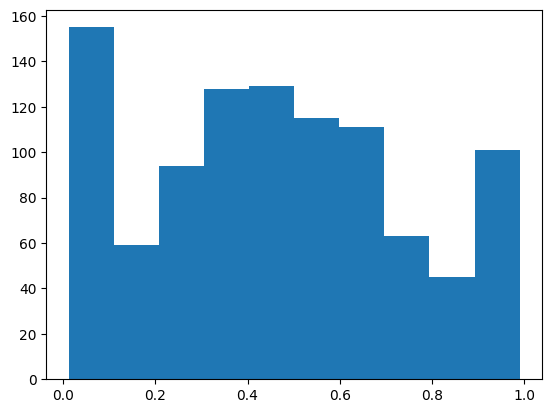

In [47]:
plt.hist(accuracy_list)

In [48]:
len(apt_hmm.eprob.keys())

25

# Noisy Constrained Simulations + Pure APT

In [39]:
B = 500
accuracy_list = []
valid_list = []
type1err_know = []
type2err_know = []
match_know = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    apt_truth_states, apt_truth_emits = apt_truth
    opt_state =  mv.mv_Viterbi(obs = combined_emits, hmm = apt_hmm)
    true_valid, true_knowledge = ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list, return_knowledge = True)
    infer_valid, infer_knowledge = ahlp.check_valid(opt_state, combined_emits, cst_list, return_knowledge = True)
    if not true_valid:
        print('Invalid sequence')
    valid_list.append(infer_valid)
    type1err_know.append(len(infer_knowledge - true_knowledge))
    type2err_know.append(len(true_knowledge - infer_knowledge))
    match_know.append(len(true_knowledge.intersection(infer_knowledge)))
    num_correct = [opt == truth for opt,truth in zip(opt_state,apt_truth_states)]
    if b % 100 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))
print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))}')
print(f'Valid proportion:{sum(valid_list)/len(valid_list)} Knowledge match: {sum(match_know)/len(match_know)} \
Type1err:{sum(type1err_know)/len(type1err_know)} Type2err:{sum(type2err_know)/len(type2err_know)}')

0
100
200
300
400
average proportion correct is 0.3288409238979773 and median is 0.35285714285714287
Valid proportion:0.01 Knowledge match: 2.652 Type1err:0.0 Type2err:3.348


In [43]:
# B = 1000
# accuracy_list = []
# for b in range(B):
#     apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
#     apt_truth_states, apt_truth_emits = apt_truth
#     opt_state =  mv.mv_Viterbi(obs = combined_emits, hmm = apt_hmm)
#     if not ahlp.check_valid(*apt_truth, cst_list):
#         print('Invalid sequence')
#     num_correct = [opt == truth for opt,truth in zip(opt_state,apt_truth_states)]
#     if b % 100 == 0:
#         print(b)
#     accuracy_list.append(sum(num_correct)/len(num_correct))
# print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
# {np.median(np.array(accuracy_list))}')

0
100
200
300
400
500
600
700
800
900
average proportion correct is 0.3356266712625735 and median is 0.36626016260162597


(array([144.,  24.,  70., 186., 286., 178.,  75.,  21.,  15.,   1.]),
 array([0.00280112, 0.08730362, 0.17180611, 0.25630861, 0.34081111,
        0.4253136 , 0.5098161 , 0.5943186 , 0.67882109, 0.76332359,
        0.84782609]),
 <BarContainer object of 10 artists>)

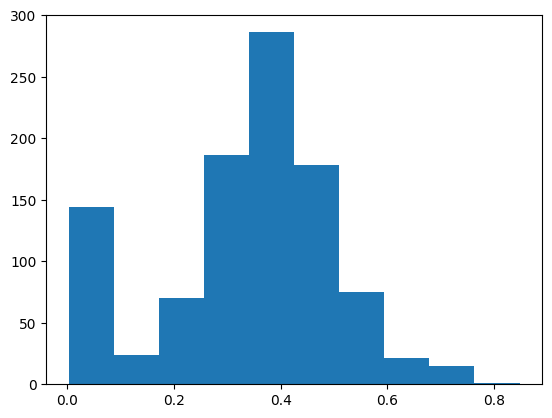

In [44]:
plt.hist(accuracy_list)

# Noisy Constrained Simulations + Noisy Base APT

In [57]:
noisy_apt = ahlp.create_noisy_apt(apt_hmm, .81)
apt_params = ahlp.hmm2numpy(noisy_apt)
print(f'initprob:{apt_params[0].sum()}  tprob: {apt_params[1].sum(axis = 1)}  eprob: {apt_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [58]:
len(apt_hmm.eprob.keys())

25

In [59]:
B = 500
accuracy_list = []
valid_list = []
type1err_know = []
type2err_know = []
match_know = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    apt_truth_states, apt_truth_emits = apt_truth
    opt_state =  mv.mv_Viterbi(obs = combined_emits, hmm = noisy_apt)
    true_valid, true_knowledge = ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list, return_knowledge = True)
    infer_valid, infer_knowledge = ahlp.check_valid(opt_state, combined_emits, cst_list, return_knowledge = True)
    if not true_valid:
        print('Invalid sequence')
    valid_list.append(infer_valid)
    type1err_know.append(len(infer_knowledge - true_knowledge))
    type2err_know.append(len(true_knowledge - infer_knowledge))
    match_know.append(len(true_knowledge.intersection(infer_knowledge)))
    num_correct = [opt == truth for opt,truth in zip(opt_state,apt_truth_states)]
    if b % 100 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))
print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))}')
print(f'Valid proportion:{sum(valid_list)/len(valid_list)} Knowledge match: {sum(match_know)/len(match_know)} \
Type1err:{sum(type1err_know)/len(type1err_know)} Type2err:{sum(type2err_know)/len(type2err_know)}')

0
100
200
300
400
average proportion correct is 0.13633647584233918 and median is 0.08888069658029632
Valid proportion:0.0 Knowledge match: 1.724 Type1err:0.0 Type2err:4.276


In [51]:
# B = 1000
# accuracy_list = []
# for b in range(B):
#     apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
#     apt_truth_states, apt_truth_emits = apt_truth
#     opt_state =  mv.mv_Viterbi(obs = combined_emits, hmm = noisy_apt)
#     num_correct = [opt == truth for opt,truth in zip(opt_state,apt_truth_states)]
#     if b % 100 == 0:
#         print(b)
#     accuracy_list.append(sum(num_correct)/len(num_correct))
# print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
# {np.median(np.array(accuracy_list))}')

0
100
200
300
400
500
600
700
800
900
average proportion correct is 0.0719761947733759 and median is 0.054949096117369256


(array([397., 318., 135.,  78.,  35.,  21.,   7.,   6.,   2.,   1.]),
 array([0.00430108, 0.04487097, 0.08544086, 0.12601075, 0.16658065,
        0.20715054, 0.24772043, 0.28829032, 0.32886022, 0.36943011,
        0.41      ]),
 <BarContainer object of 10 artists>)

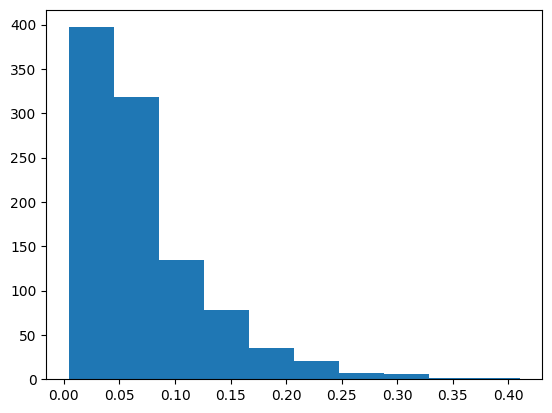

In [53]:
plt.hist(accuracy_list)

# Augmented HMM  for Constrained Inference

# Constrained Simulation + Model (Tiered APT) with no emission prob noise. 

Noticed there are some runs where it returns a nonsense sequence of just "PRE".

Looking at the value function, it collapses to 0 at some time. Observations seem to indicate that the issue might be impossible inference (since no noise in emissions) vs. numerical underflow


In [47]:
import time

In [48]:
tier_apt.states[:10]

[('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('EX', ('V', 'access/bob')),
 ('EX', ('V', 'access/sally')),
 ('EX', ('S', 'postfix/local')),
 ('EX', ('HI', 'img/post')),
 ('EX', ('HE', 'img/post')),
 ('EX', ('DS', 'syslog/nano')),
 ('DI', ('S', 'postfix/local')),
 ('DI', ('HI', 'usr/query'))]

In [49]:
list(tier_apt.tprob.keys())[:10]

[(('PRE', None), ('PRE', None)),
 (('PRE', None), ('IA', ('S', 'postfix/local'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('V', 'access/bob'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('V', 'access/sally'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('S', 'postfix/local'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('HI', 'img/post'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('HE', 'img/post'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('DS', 'syslog/nano'))),
 (('IA', ('S', 'postfix/local')), ('WAIT_IA', None)),
 (('EX', ('V', 'access/bob')), ('EX', ('V', 'access/bob')))]

In [50]:
tier_apt.eprob

defaultdict(int,
            {(('PRE', None), None): 1.0,
             (('IA', ('S', 'postfix/local')), ('S', 'postfix/local')): 1.0,
             (('EX', ('V', 'access/bob')), ('V', 'access/bob')): 1.0,
             (('EX', ('V', 'access/sally')), ('V', 'access/sally')): 1.0,
             (('EX', ('S', 'postfix/local')), ('S', 'postfix/local')): 1.0,
             (('EX', ('HI', 'img/post')), ('HI', 'img/post')): 1.0,
             (('EX', ('HE', 'img/post')), ('HE', 'img/post')): 1.0,
             (('EX', ('DS', 'syslog/nano')), ('DS', 'syslog/nano')): 1.0,
             (('DI', ('S', 'postfix/local')), ('S', 'postfix/local')): 1.0,
             (('DI', ('HI', 'usr/query')), ('HI', 'usr/query')): 1.0,
             (('DI', ('HI', 'img/query')), ('HI', 'img/query')): 1.0,
             (('DI', ('HE', 'img/query')), ('HE', 'img/query')): 1.0,
             (('DI', ('DS', 'syslog/ls')), ('DS', 'syslog/ls')): 1.0,
             (('CA', ('HI', 'usr/query')), ('HI', 'usr/query')): 1.0,
          

In [51]:
list(tier_apt.eprob.keys())[:10]

[(('PRE', None), None),
 (('IA', ('S', 'postfix/local')), ('S', 'postfix/local')),
 (('EX', ('V', 'access/bob')), ('V', 'access/bob')),
 (('EX', ('V', 'access/sally')), ('V', 'access/sally')),
 (('EX', ('S', 'postfix/local')), ('S', 'postfix/local')),
 (('EX', ('HI', 'img/post')), ('HI', 'img/post')),
 (('EX', ('HE', 'img/post')), ('HE', 'img/post')),
 (('EX', ('DS', 'syslog/nano')), ('DS', 'syslog/nano')),
 (('DI', ('S', 'postfix/local')), ('S', 'postfix/local')),
 (('DI', ('HI', 'usr/query')), ('HI', 'usr/query'))]

In [41]:
B = 100
accuracy_list = []
valid_list = []
type1err_know = []
type2err_know = []
match_know = []
time_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    apt_truth_states, apt_truth_emits = apt_truth
    start_time = time.time()
    opt_state_list, _= ahlp.Viterbi_torch_list(tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float32, device = 'cuda:0')
    running_time = time.time() - start_time
    opt_hidden, opt_emits = zip(*opt_state_list)
    true_valid, true_knowledge = ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list, return_knowledge = True)
    infer_valid, infer_knowledge = ahlp.check_valid(opt_hidden, opt_emits, cst_list, return_knowledge = True)
    time_list.append(running_time)
    valid_list.append(infer_valid)
    type1err_know.append(len(infer_knowledge - true_knowledge))
    type2err_know.append(len(true_knowledge - infer_knowledge))
    match_know.append(len(true_knowledge.intersection(infer_knowledge)))
    num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
    if b % 10 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))    

print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)}')
print(f'Valid proportion:{sum(valid_list)/len(valid_list)} Knowledge match: {sum(match_know)/len(match_know)} \
Type1err:{sum(type1err_know)/len(type1err_know)} Type2err:{sum(type2err_know)/len(type2err_know)}')

0
10
20
30
40
50
60
70
80
90
average proportion correct is 0.09066303371456412 and median is 0.01829186730872124 and avgtime:0.9463747978210449
Valid proportion:1.0 Knowledge match: 0.68 Type1err:0.0 Type2err:5.32


In [ ]:
plt.hist(accuracy_list)

## Code for Checking Cause of Junk Inference.

Look at value function. It collapses at some time.

In [26]:
apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
apt_truth_states, apt_truth_emits = apt_truth
opt_state_list, _, val, ix_tracker = ahlp.Viterbi_torch_list(tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float16, device = 'cuda:0', debug = True)

In [27]:
opt_state_list[:10]

[('PRE', None),
 ('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('EX', ('S', 'postfix/local'))]

In [28]:
for t in range(val.shape[0]):
    # if torch.isnan(val[t].max()):
    #     print(t)
    if val[t].max().item() <= 0:
        print(f'value function collapses at time {t}')
        break

In [29]:
opt_hidden, opt_emits = zip(*opt_state_list)
ahlp.check_valid(opt_hidden,opt_emits,cst_list)

True

In [57]:
# np.histogram(val[1].flatten().numpy(), bins=10)

# Tiered APT with Noisy Emissions and Const

Doesn't seem to give sequneces of "PRE"s like APT with no noise in the emissions.

# Mixture with Uniform: 1/3

In [45]:
noisy_tier_apt = ahlp.create_noisy_apt(tier_apt, 1/3)

In [46]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [47]:
B = 100
accuracy_list = []
valid_list = []
type1err_know = []
type2err_know = []
match_know = []
time_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    apt_truth_states, apt_truth_emits = apt_truth
    start_time = time.time()
    opt_state_list, _= ahlp.Viterbi_torch_list(noisy_tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
    running_time = time.time() - start_time
    opt_hidden, opt_emits = zip(*opt_state_list)
    true_valid, true_knowledge = ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list, return_knowledge = True)
    infer_valid, infer_knowledge = ahlp.check_valid(opt_hidden, opt_emits, cst_list, return_knowledge = True)
    time_list.append(running_time)
    valid_list.append(infer_valid)
    type1err_know.append(len(infer_knowledge - true_knowledge))
    type2err_know.append(len(true_knowledge - infer_knowledge))
    match_know.append(len(true_knowledge.intersection(infer_knowledge)))
    num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
    if b % 10 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))    

print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)}')
print(f'Valid proportion:{sum(valid_list)/len(valid_list)} Knowledge match: {sum(match_know)/len(match_know)} \
Type1err:{sum(type1err_know)/len(type1err_know)} Type2err:{sum(type2err_know)/len(type2err_know)}')

0
10
20
30
40
50
60
70
80
90
average proportion correct is 0.07196702784400281 and median is 0.056330128205128206 and avgtime:0.9756428575515748
Valid proportion:1.0 Knowledge match: 4.2 Type1err:0.0 Type2err:1.8


In [105]:
# B = 50
# accuracy_list = []
# time_list = []
# valid_list = []

# for b in range(B):
#     apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
#     apt_truth_states, apt_truth_emits = apt_truth
#     start_time = time.time()
#     opt_state_list, _= ahlp.Viterbi_torch_list(noisy_tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
#     running_time = time.time() - start_time
#     time_list.append(running_time)
#     opt_hidden, opt_emits = zip(*opt_state_list)
#     valid_list.append(ahlp.check_valid(opt_hidden, opt_emits, cst_list))
#     num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
#     if b % 10 == 0:
#         print(b)
#     accuracy_list.append(sum(num_correct)/len(num_correct))
# print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
# {np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)} \
# and proportion valid: {sum(valid_list)/len(valid_list)}')

0
10
20
30
40
average proportion correct is 0.07905176791083657 and median is 0.05974338412189254 and avgtime:1.01936954498291 and proportion valid: 1.0


(array([2., 5., 4., 7., 7., 3., 4., 3., 1., 0., 4., 1., 3., 1., 2., 0., 1.,
        0., 1., 1.]),
 array([0.00506329, 0.01613088, 0.02719847, 0.03826606, 0.04933365,
        0.06040124, 0.07146883, 0.08253642, 0.09360401, 0.1046716 ,
        0.11573919, 0.12680678, 0.13787437, 0.14894196, 0.16000955,
        0.17107714, 0.18214473, 0.19321232, 0.20427991, 0.2153475 ,
        0.22641509]),
 <BarContainer object of 20 artists>)

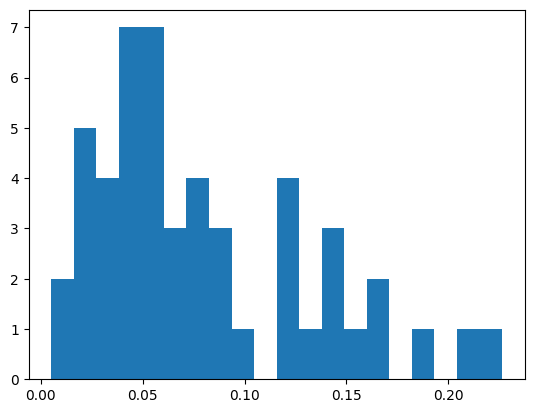

In [106]:
plt.hist(accuracy_list, bins = 20)

# Mixture with Uniform: 2/3

In [52]:
less_noisy_tier_apt = ahlp.create_noisy_apt(tier_apt, 2/3)

In [53]:
B = 100
accuracy_list = []
valid_list = []
type1err_know = []
type2err_know = []
match_know = []
time_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    apt_truth_states, apt_truth_emits = apt_truth
    start_time = time.time()
    opt_state_list, _= ahlp.Viterbi_torch_list(less_noisy_tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
    running_time = time.time() - start_time
    opt_hidden, opt_emits = zip(*opt_state_list)
    true_valid, true_knowledge = ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list, return_knowledge = True)
    infer_valid, infer_knowledge = ahlp.check_valid(opt_hidden, opt_emits, cst_list, return_knowledge = True)
    time_list.append(running_time)
    valid_list.append(infer_valid)
    type1err_know.append(len(infer_knowledge - true_knowledge))
    type2err_know.append(len(true_knowledge - infer_knowledge))
    match_know.append(len(true_knowledge.intersection(infer_knowledge)))
    num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
    if b % 10 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))    

print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)}')
print(f'Valid proportion:{sum(valid_list)/len(valid_list)} Knowledge match: {sum(match_know)/len(match_know)} \
Type1err:{sum(type1err_know)/len(type1err_know)} Type2err:{sum(type2err_know)/len(type2err_know)}')

ValueError: too many values to unpack (expected 2)

In [54]:
B = 100
accuracy_list = []
valid_list = []
type1err_know = []
type2err_know = []
match_know = []
time_list = []
knowledge_times = []
time_tol  = 5
exact_match_list = []
tol_match_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    apt_truth_states, apt_truth_emits = apt_truth
    start_time = time.time()
    opt_state_list, _= ahlp.Viterbi_torch_list(less_noisy_tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
    running_time = time.time() - start_time
    opt_hidden, opt_emits = zip(*opt_state_list)
    true_valid, true_knowledge, true_times = ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list, return_knowledge = True)
    infer_valid, infer_knowledge, infer_times = ahlp.check_valid(opt_hidden, opt_emits, cst_list, return_knowledge = True)
    tol_match = ahlp.check_within_distance(true_times, infer_times, time_tol)
    knowledge_times.append(tol_match)
    tol_match_list.append(sum(tol_match))
    exact_match_list.append(sum([true == infer for true,infer in zip(true_times,infer_times)]))
    time_list.append(running_time)
    valid_list.append(infer_valid)
    type1err_know.append(len(infer_knowledge - true_knowledge))
    type2err_know.append(len(true_knowledge - infer_knowledge))
    match_know.append(len(true_knowledge.intersection(infer_knowledge)))
    num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
    if b % 100 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))    

time_match = [sum(times) / len(knowledge_times) for times in zip(*knowledge_times)]
final_times = {c.name: time for c,time in zip(cst_list,time_match)}
print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)}')
print(f'Valid proportion:{sum(valid_list)/len(valid_list)} Knowledge match: {sum(match_know)/len(match_know)} \
Type1err:{sum(type1err_know)/len(type1err_know)} Type2err:{sum(type2err_know)/len(type2err_know)}')
print(final_times)
print(f'Avg number of exact matches:{sum(exact_match_list)/len(exact_match_list)}')

0
average proportion correct is 0.12987585228625081 and median is 0.07400554040600787 and avgtime:1.0635735058784486
Valid proportion:1.0 Knowledge match: 5.52 Type1err:0.0 Type2err:0.48
{'know_sally_exists': 0.27, 'have_sally_credential': 0.14, 'learn_where_data_stored': 0.09, 'have_data_on_ds': 0.08, 'have_data_on_hi': 0.07, 'have_data_on_he': 0.09}
Avg number of exact matches:0.58


In [ ]:
mix_tier_apt = tier_mixture(tier_apt, user_list, length, mix_weights = None, return_ix = False):


(array([13., 14.,  6.,  5.,  4.,  3.,  1.,  1.,  2.,  1.]),
 array([0.00443459, 0.05021755, 0.0960005 , 0.14178346, 0.18756641,
        0.23334937, 0.27913233, 0.32491528, 0.37069824, 0.41648119,
        0.46226415]),
 <BarContainer object of 10 artists>)

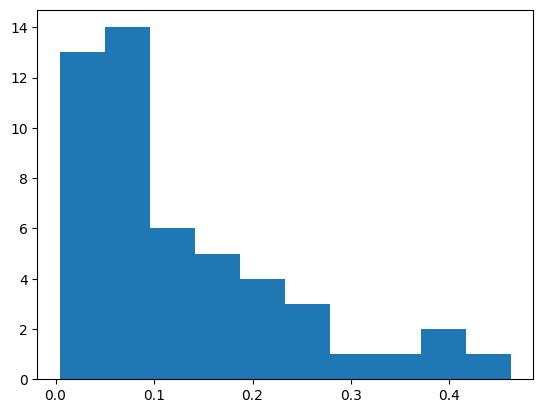

In [109]:
plt.hist(accuracy_list)

## Code for Checking Cause of Junk Inference.

Look at value function. It collapses at some time.

In [90]:
apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
apt_truth_states, apt_truth_emits = apt_truth
opt_state_list, _, val, ix_tracker = ahlp.Viterbi_torch_list(less_noisy_tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float16, device = 'cuda:0', debug = True)

In [91]:
opt_state_list[20:30]

[('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None)]

In [92]:
for t in range(val.shape[0]):
    # if torch.isnan(val[t].max()):
    #     print(t)
    if val[t].max().item() <= 0:
        print(f'value function collapses at time {t}')
        break

In [93]:
opt_hidden, opt_emits = zip(*opt_state_list)
ahlp.check_valid(opt_hidden,opt_emits,cst_list)

True

# Mixture with Calibration

$\mu_i$ is the probability that each user doesn't have an emission at a given time, so by independence $ 1 - \prod_i \mu_i $ is the probability that there is at least one user emission at some time. Use this as our mixing parameter.

In [22]:
mix_param = mu_list[1]*mu_list[2]

In [23]:
optmix_noisy_tier_apt = ahlp.create_noisy_apt(tier_apt, mix_param)

In [24]:
cst_list[0].name

'know_sally_exists'

In [25]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [26]:
B = 1000
accuracy_list = []
valid_list = []
type1err_know = []
type2err_know = []
match_know = []
time_list = []
knowledge_times = []
time_tol  = 5
exact_match_list = []
tol_match_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    apt_truth_states, apt_truth_emits = apt_truth
    start_time = time.time()
    opt_state_list, _= ahlp.Viterbi_torch_list(optmix_noisy_tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
    running_time = time.time() - start_time
    opt_hidden, opt_emits = zip(*opt_state_list)
    true_valid, true_knowledge, true_times = ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list, return_knowledge = True)
    infer_valid, infer_knowledge, infer_times = ahlp.check_valid(opt_hidden, opt_emits, cst_list, return_knowledge = True)
    tol_match = ahlp.check_within_distance(true_times, infer_times, time_tol)
    knowledge_times.append(tol_match)
    tol_match_list.append(sum(tol_match))
    exact_match_list.append(sum([true == infer for true,infer in zip(true_times,infer_times)]))
    time_list.append(running_time)
    valid_list.append(infer_valid)
    type1err_know.append(len(infer_knowledge - true_knowledge))
    type2err_know.append(len(true_knowledge - infer_knowledge))
    match_know.append(len(true_knowledge.intersection(infer_knowledge)))
    num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
    if b % 100 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))    

time_match = [sum(times) / len(knowledge_times) for times in zip(*knowledge_times)]
final_times = {c.name: time for c,time in zip(cst_list,time_match)}
print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)}')
print(f'Valid proportion:{sum(valid_list)/len(valid_list)} Knowledge match: {sum(match_know)/len(match_know)} \
Type1err:{sum(type1err_know)/len(type1err_know)} Type2err:{sum(type2err_know)/len(type2err_know)}')
print(final_times)
print(f'Avg number of exact matches:{sum(exact_match_list)/len(exact_match_list)}')

0
100
200
300
400
500
600
700
800
900
average proportion correct is 0.2841993401248104 and median is 0.15866460444912467 and avgtime:0.966603229522705
Valid proportion:1.0 Knowledge match: 5.99 Type1err:0.0 Type2err:0.01
{'know_sally_exists': 0.529, 'have_sally_credential': 0.278, 'learn_where_data_stored': 0.283, 'have_data_on_ds': 0.255, 'have_data_on_hi': 0.286, 'have_data_on_he': 0.257}
Avg number of exact matches:1.638


Text(0.5, 1.0, 'Knowledge Times Exact Match')

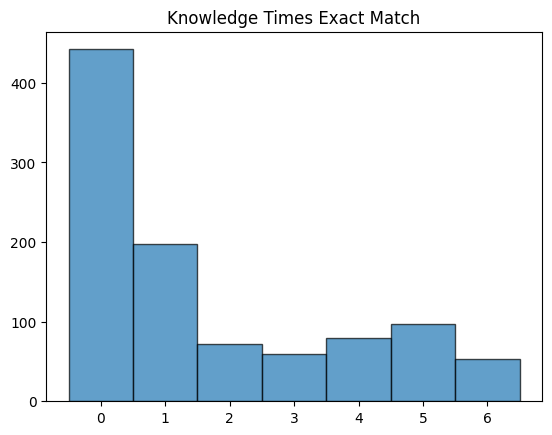

In [33]:
# Specify the bin edges
bins = [-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5]  # Define the edges of the bins

# Create the histogram
plt.hist(exact_match_list, bins=bins, edgecolor='black', alpha=0.7)
plt.title('Knowledge Times Exact Match')

Text(0.5, 1.0, 'Knowledge Times within 5 Timesteps')

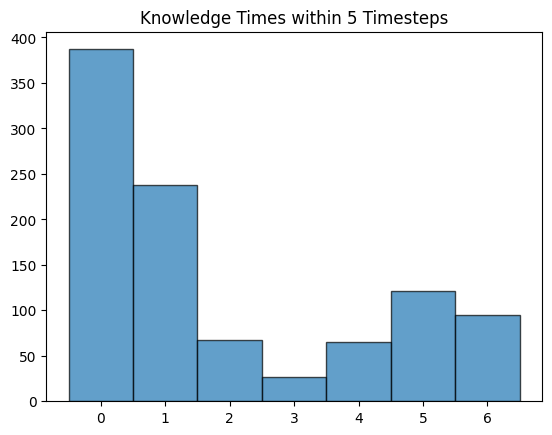

In [35]:
# Specify the bin edges
bins = [-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5]  # Define the edges of the bins

# Create the histogram
plt.hist(tol_match_list, bins=bins, edgecolor='black', alpha=0.7)
plt.title(f'Knowledge Times within {time_tol} Timesteps')

In [109]:
name_list = []
for c in cst_list:
    name_list.append(c.name)
print(name_list)

['know_sally_exists', 'have_sally_credential', 'learn_where_data_stored', 'have_data_on_ds', 'have_data_on_hi', 'have_data_on_he']


In [ ]:
['know_sally_exists', 'have_sally_credential', 'learn_where_data_stored', 'have_data_on_ds', 'have_data_on_hi', 'have_data_on_he']


In [ ]:
# Time deviation + num times

In [33]:
# B = 50
# accuracy_list = []
# time_list = []
# valid_list = []

# for b in range(B):
#     apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
#     apt_truth_states, apt_truth_emits = apt_truth
#     start_time = time.time()
#     opt_state_list, _= ahlp.Viterbi_torch_list(less_noisy_tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
#     running_time = time.time() - start_time
#     time_list.append(running_time)
#     opt_hidden, opt_emits = zip(*opt_state_list)
#     valid_list.append(ahlp.check_valid(opt_hidden, opt_emits, cst_list))
#     num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
#     if b % 10 == 0:
#         print(b)
#     accuracy_list.append(sum(num_correct)/len(num_correct))
# print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
# {np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)} \
# and proportion valid: {sum(valid_list)/len(valid_list)}')

0
10
20
30
40
average proportion correct is 0.3123832204811109 and median is 0.15894736842105261 and avgtime:0.9543452692031861 and proportion valid: 1.0


In [ ]:
mix_tier_apt = tier_mixture(tier_apt, user_list, length, mix_weights = None, return_ix = False):


(array([13., 14.,  6.,  5.,  4.,  3.,  1.,  1.,  2.,  1.]),
 array([0.00443459, 0.05021755, 0.0960005 , 0.14178346, 0.18756641,
        0.23334937, 0.27913233, 0.32491528, 0.37069824, 0.41648119,
        0.46226415]),
 <BarContainer object of 10 artists>)

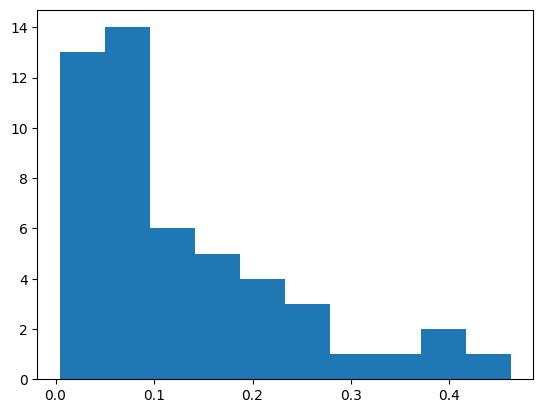

In [109]:
plt.hist(accuracy_list)

# Mixture of Marginals

Now, we adaptively change the emission probabiltiy at time $t$ to be a mixture of margainsl. By default, mixture parameters are uniform over hte distributions in the mixture.

In [47]:
list(tier_apt.tprob.keys())[:10]

[(('PRE', None), ('PRE', None)),
 (('PRE', None), ('IA', ('S', 'postfix/local'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('V', 'access/bob'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('V', 'access/sally'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('S', 'postfix/local'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('HI', 'img/post'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('HE', 'img/post'))),
 (('IA', ('S', 'postfix/local')), ('EX', ('DS', 'syslog/nano'))),
 (('IA', ('S', 'postfix/local')), ('WAIT_IA', None)),
 (('EX', ('V', 'access/bob')), ('EX', ('V', 'access/bob')))]

```mix_param``` is $1-\prod_i \mu$ over all users. Therefore, with $N$ useres the mixture is:

$$ P(E|H) = (1-\prod_i \mu_i)P_{apt}(E|H) + \frac{\prod_i \mu_i}{N} \sum_i P_i(E|H)$$

In [69]:
B = 100
# mix_weights = np.array(2*[round((1-mix_param)/2,5)])
mix_weights = np.array([.33,.33])
accuracy_list = []
valid_list = []
type1err_know = []
type2err_know = []
match_know = []
time_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    apt_truth_states, apt_truth_emits = apt_truth
    mix_apt = ahlp.tier_mixture(tier_apt, user_list, len(combined_emits), mix_weights = mix_weights, return_ix = False)
    start_time = time.time()
    opt_state_list, _= ahlp.Viterbi_torch_list(mix_apt, cst_list, combined_emits, sat, time_hom = False, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
    running_time = time.time() - start_time
    opt_hidden, opt_emits = zip(*opt_state_list)
    true_valid, true_knowledge = ahlp.check_valid(apt_truth_states, apt_truth_emits, cst_list, return_knowledge = True)
    infer_valid, infer_knowledge = ahlp.check_valid(opt_hidden, opt_emits, cst_list, return_knowledge = True)
    time_list.append(running_time)
    valid_list.append(infer_valid)
    type1err_know.append(len(infer_knowledge - true_knowledge))
    type2err_know.append(len(true_knowledge - infer_knowledge))
    match_know.append(len(true_knowledge.intersection(infer_knowledge)))
    num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
    if b % 10 == 0:
        print(b)
    accuracy_list.append(sum(num_correct)/len(num_correct))    

print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
{np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)}')
print(f'Valid proportion:{sum(valid_list)/len(valid_list)} Knowledge match: {sum(match_know)/len(match_know)} \
Type1err:{sum(type1err_know)/len(type1err_know)} Type2err:{sum(type2err_know)/len(type2err_know)}')

0
10
20
30
40
50
60
70
80
90
average proportion correct is 0.017796218292739075 and median is 0.011738382099827884 and avgtime:2.3562044048309327
Valid proportion:1.0 Knowledge match: 0.0 Type1err:0.0 Type2err:6.0


In [73]:
# B = 50
# accuracy_list = []
# time_list = []
# valid_list = []
# mix_weights = np.array(2*[round((1-mix_param)/2,5)])

# for b in range(B):
#     apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
#     apt_truth_states, apt_truth_emits = apt_truth
#     mix_apt = ahlp.tier_mixture(tier_apt, user_list, len(combined_emits), mix_weights = mix_weights, return_ix = False)
#     start_time = time.time()
#     opt_state_list, _= ahlp.Viterbi_torch_list(mix_apt, cst_list, combined_emits, sat, time_hom = False, dtype = torch.float32, device = 'cuda:0', num_cst = 0)
#     running_time = time.time() - start_time
#     time_list.append(running_time)
#     opt_hidden, opt_emits = zip(*opt_state_list)
#     valid_list.append(ahlp.check_valid(opt_hidden, opt_emits, cst_list))
#     num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
#     if b % 10 == 0:
#         print(b)
#     accuracy_list.append(sum(num_correct)/len(num_correct))
# print(f'average proportion correct is {sum(accuracy_list)/len(accuracy_list)} and median is \
# {np.median(np.array(accuracy_list))} and avgtime:{sum(time_list)/len(time_list)} \
# and proportion valid: {sum(valid_list)/len(valid_list)}')

0
10
20
30
40
average proportion correct is 0.016726884239644756 and median is 0.013423423423423425 and avgtime:2.0099761486053467 and proportion valid: 1.0


In [55]:
isinstance(mix_apt.tprob, dict)

True

In [ ]:
mix_tier_apt = tier_mixture(tier_apt, user_list, length, mix_weights = None, return_ix = False):


(array([13., 14.,  6.,  5.,  4.,  3.,  1.,  1.,  2.,  1.]),
 array([0.00443459, 0.05021755, 0.0960005 , 0.14178346, 0.18756641,
        0.23334937, 0.27913233, 0.32491528, 0.37069824, 0.41648119,
        0.46226415]),
 <BarContainer object of 10 artists>)

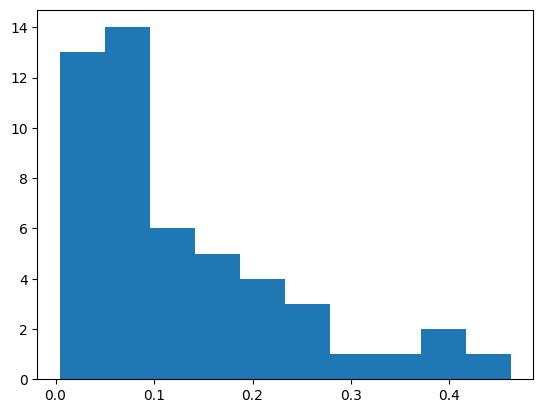

In [109]:
plt.hist(accuracy_list)

In [229]:
apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
apt_truth_states, apt_truth_emits = apt_truth
opt_state_list, _, val, ix_tracker = ahlp.Viterbi_torch_list(noisy_tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float16, device = 'cuda:0', debug = True)

In [230]:
opt_hidden, opt_emits = zip(*opt_state_list)
ahlp.check_valid(opt_hidden,opt_emits,cst_list)

False

In [233]:
apt_truth_states[:20]

['PRE',
 'PRE',
 'PRE',
 'PRE',
 'PRE',
 'PRE',
 'PRE',
 'PRE',
 'PRE',
 'PRE',
 'PRE',
 'PRE',
 'IA',
 'WAIT_IA',
 'EX',
 'WAIT_EX',
 'DI',
 'WAIT_DI',
 'WAIT_DI',
 'WAIT_DI']

In [177]:
opt_state_list[:10]

[('PRE', None),
 ('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None)]

# WQRK

In [376]:
sally_cst

Munch({'name': 'know_sally_exists', 'aux_size': 1, 'update_fun': <function update_fun at 0x7f16a8e19f80>, 'init_fun': <function init_fun at 0x7f165d912840>, 'forbidden_emissions': [('CA', ('HI', 'usr/query'))], 'forbidden_transitions': [('EX', 'CA'), ('WAIT_EX', 'CA'), ('DI', 'CA'), ('WAIT_DI', 'CA')], 'knowledge_state': ('DI', ('HI', 'usr/query')), 'cst_fun': <function cst_fun at 0x7f165d0f1a80>})

In [377]:
sally_cst.init_fun( tier_apt.states[9], (True,))

1

In [383]:
tier_apt.states

[('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('EX', ('V', 'access/bob')),
 ('EX', ('V', 'access/sally')),
 ('EX', ('S', 'postfix/local')),
 ('EX', ('HI', 'img/post')),
 ('EX', ('HE', 'img/post')),
 ('EX', ('DS', 'syslog/nano')),
 ('DI', ('S', 'postfix/local')),
 ('DI', ('HI', 'usr/query')),
 ('DI', ('HI', 'img/query')),
 ('DI', ('HE', 'img/query')),
 ('DI', ('DS', 'syslog/ls')),
 ('CA', ('HI', 'usr/query')),
 ('COL', ('HI', 'img/post')),
 ('COL', ('HE', 'img/post')),
 ('COL', ('DS', 'syslog/nano')),
 ('EXF', ('HE', 'img/query')),
 ('POST', None),
 ('WAIT_CA', None),
 ('WAIT_COL', None),
 ('WAIT_DI', None),
 ('WAIT_IA', None),
 ('WAIT_EXF', None),
 ('WAIT_EX', None)]

In [382]:
sally_cst.forbidden_transitions

[('EX', 'CA'), ('WAIT_EX', 'CA'), ('DI', 'CA'), ('WAIT_DI', 'CA')]

In [387]:
sally_cst.name

'know_sally_exists'

In [389]:
k,r ,k_past, r_past = ('EX', ('S', 'postfix/local')),(False,),('CA', ('HI', 'usr/query')), (False,)

In [394]:
    m1 = (k == ('DI',('HI','usr/query'))) or r_past[0] #tracks if knowledge state has occured yet
    forbidden_transitions = (k_past[0] == 'EX' and k[0] == 'CA') or (k_past[0] == 'DI' and k[0] == 'CA')
    forbidden_emissions = (k == ('CA',('HI','usr/query')))
    m2 = (m1 or (not (forbidden_transitions and forbidden_emissions)))


In [395]:
k_past[0]

'CA'

In [398]:
sally_cst.update_fun(('CA', ('HI', 'usr/query')), (True,),('EX', ('S', 'postfix/local')), (True,))

1

In [399]:
it = 0
aux_space = list(itertools.product([True, False], repeat=sally_cst.aux_size))

# for k in tier_apt.states:
k = ('CA', ('HI', 'usr/query'))
for r in aux_space:
    for j in tier_apt.states:
        for s in aux_space:
            if it > 100:
                break
            print(k,r,j,s,sally_cst.update_fun(k,r,j,s))
            it += 1

('CA', ('HI', 'usr/query')) (True,) ('PRE', None) (True,) 1
('CA', ('HI', 'usr/query')) (True,) ('PRE', None) (False,) 0
('CA', ('HI', 'usr/query')) (True,) ('IA', ('S', 'postfix/local')) (True,) 1
('CA', ('HI', 'usr/query')) (True,) ('IA', ('S', 'postfix/local')) (False,) 0
('CA', ('HI', 'usr/query')) (True,) ('EX', ('V', 'access/bob')) (True,) 1
('CA', ('HI', 'usr/query')) (True,) ('EX', ('V', 'access/bob')) (False,) 0
('CA', ('HI', 'usr/query')) (True,) ('EX', ('V', 'access/sally')) (True,) 1
('CA', ('HI', 'usr/query')) (True,) ('EX', ('V', 'access/sally')) (False,) 0
('CA', ('HI', 'usr/query')) (True,) ('EX', ('S', 'postfix/local')) (True,) 1
('CA', ('HI', 'usr/query')) (True,) ('EX', ('S', 'postfix/local')) (False,) 0
('CA', ('HI', 'usr/query')) (True,) ('EX', ('HI', 'img/post')) (True,) 1
('CA', ('HI', 'usr/query')) (True,) ('EX', ('HI', 'img/post')) (False,) 0
('CA', ('HI', 'usr/query')) (True,) ('EX', ('HE', 'img/post')) (True,) 1
('CA', ('HI', 'usr/query')) (True,) ('EX', ('HE

In [359]:
tier_apt.states[9]

('DI', ('HI', 'usr/query'))

In [354]:
tier_apt = ahlp.create_tiered_apt(apt_hmm, tol = 1e-7)

In [357]:
len(tier_apt.tprob)

252

In [361]:
apt_params, cst_params = ahlp.convertTensor_list(tier_apt, cst_list, sat, dtype = torch.float16, device = 'cpu', return_ix = False)


In [331]:
def convertTensor_list(hmm, cst_list, sat, dtype = torch.float16, device = 'cpu', return_ix = False):
    '''
    cst_list is a list of the individual csts.
    '''
    #Initialize and convert all quantities  to np.arrays
    hmm = copy.deepcopy(hmm)
    K = len(hmm.states)
    assert len(cst_list) == len(sat)
    
    state_ix = {s: i for i, s in enumerate(hmm.states)}

    #Compute the hmm parameters
    tmat = torch.zeros((K,K), dtype=dtype ).to(device)
    init_prob = torch.zeros(K, dtype=dtype ).to(device)

    for i in hmm.states:
        init_prob[state_ix[i]] = hmm.initprob[i]
        for j in hmm.states:
            tmat[state_ix[i],state_ix[j]] = hmm.tprob[i,j]

    hmm_params = [tmat, init_prob]
    
    #Compute the cst parameters 
    init_ind_list = []
    final_ind_list = []
    ind_list = []
    dims_list = []
    cst_ix = 0
    C = len(cst_list)
    for cst in cst_list:
        cst = copy.deepcopy(cst)
        aux_space = list(itertools.product([True, False], repeat=cst.aux_size))
        aux_ix = {s: i for i, s in enumerate(aux_space)}
        M = len(aux_space)
        ind = torch.zeros((K,M,K,M),dtype=dtype ).to(device)
        init_ind = torch.zeros((K,M),dtype=dtype ).to(device)
        final_ind = torch.zeros((K,M),dtype=dtype ).to(device)
    
        for r in aux_space:
            for k in hmm.states:
                final_ind[state_ix[k], aux_ix[r]] = cst.cst_fun(k,r,sat)
                init_ind[state_ix[k],aux_ix[r]] = cst.init_fun(k,r)
                for s in aux_space:
                    for j in hmm.states:
                        ind[state_ix[k],aux_ix[r],state_ix[j],aux_ix[s]] = cst.update_fun(k,r,j,s)

        #indices are [0 = k,  (1 dim for each cst r_i = i + 1)  0 <= i <= n - 1 
        # init_ind_list.append((init_ind,[0,cst_ix + 1]))
        # final_ind_list.append((final_ind, [0, cst_ix + 1]))
        # #indices are [0 = k,(1 dim for each cst r_i = i + 1), n + 1 = j, (1 dim for s_i = i+n+2)] 
        # ind_list.append((ind, [0, cst_ix + 1, C + 1, cst_ix + C + 2]))
        # dims_list.append(M)

        init_ind_list += [init_ind,[0,cst_ix + 1]]
        final_ind_list += [final_ind, [0, cst_ix + 1]]
        #indices are [0 = k,(1 dim for each cst r_i = i + 1), n + 1 = j, (1 dim for s_i = i+n+2)] 
        ind_list += [ind, [0, cst_ix + 1, C + 1, cst_ix + C + 2]]
        dims_list.append(M)
        cst_ix += 1
                
    cst_params = [dims_list, init_ind_list,final_ind_list,ind_list]

    if return_ix:
        return hmm_params, cst_params, state_ix
    return hmm_pa

In [237]:
def convertTensor_list(hmm, cst_list, sat, dtype = torch.float16, device = 'cpu', return_ix = False):
    '''
    cst_list is a list of the individual csts.
    '''
    #Initialize and convert all quantities  to np.arrays
    hmm = copy.deepcopy(hmm)
    K = len(hmm.states)
    assert len(cst_list) == len(sat)
    
    state_ix = {s: i for i, s in enumerate(hmm.states)}

    #Compute the hmm parameters
    tmat = torch.zeros((K,K), dtype=dtype ).to(device)
    init_prob = torch.zeros(K, dtype=dtype ).to(device)

    for i in hmm.states:
        init_prob[state_ix[i]] = hmm.initprob[i]
        for j in hmm.states:
            tmat[state_ix[i],state_ix[j]] = hmm.tprob[i,j]

    hmm_params = [tmat, init_prob]
    
    #Compute the cst parameters 
    init_ind_list = []
    final_ind_list = []
    ind_list = []
    dims_list = []
    cst_ix = 0
    C = len(cst_list)
    for cst in cst_list:
        cst = copy.deepcopy(cst)
        aux_space = list(itertools.product([True, False], repeat=cst.aux_size))
        aux_ix = {s: i for i, s in enumerate(aux_space)}
        M = len(aux_space)
        ind = torch.zeros((K,M,K,M),dtype=dtype ).to(device)
        init_ind = torch.zeros((K,M),dtype=dtype ).to(device)
        final_ind = torch.zeros((K,M),dtype=dtype ).to(device)
    
        for r in aux_space:
            for k in hmm.states:
                final_ind[state_ix[k], aux_ix[r]] = cst.cst_fun(k,r,sat)
                init_ind[state_ix[k],aux_ix[r]] = cst.init_fun(k,r)
                for s in aux_space:
                    for j in hmm.states:
                        ind[state_ix[k],aux_ix[r],state_ix[j],aux_ix[s]] = cst.update_fun(k,r,j,s)


In [165]:
for t in range(val.shape[0]):
    # if torch.isnan(val[t].max()):
    #     print(t)
    if val[t].max().item() <= 0:
        print(f'value function collapses at time {t}')
        break

In [166]:
opt_state_list, _, val, ix_tracker = ahlp.Viterbi_torch_list(tier_apt, cst_list, combined_emits, sat, time_hom = True, dtype = torch.float16, device = 'cuda:0', debug = True)

In [72]:
num_correct = [est[0]== true for est,true in zip(opt_state_list, apt_truth_states)]
print(sum(num_correct)/len(num_correct))

0.014492753623188406


In [756]:
num_correct = [est[0] == true for est,true in zip(opt_state_list, apt_truth_states)]
print(sum(num_correct)/len(num_correct))

0.0045045045045045045


In [ ]:
for t in range(val.shape[0]):
    # if torch.isnan(val[t].max()):
    #     print(t)
    print(val[t].max())

In [601]:
aux_space = list(itertools.product([True, False], repeat=agg_cst.aux_size)) #create list of auxillary state to iterate over


In [611]:
hmm = copy.deepcopy(apt_hmm)
cst = copy.deepcopy(agg_cst)

In [614]:
    val = {} #initialize value dictionary

    for k in hmm.states:
        for r in aux_space:
            val[0,k,r] = cst.init_fun(k,r)*hmm.initprob[k]*hmm.eprob[k,obs[0]]
            
    ix_tracker = {} #this is used in the backwards step to identify the optimal sequence


In [615]:
for t in range(1,len(obs)):
    for k in hmm.states:
        for r in aux_space:
            max_val = -1 # set to dummy variable. will do brute-force search for max
            argmax = None #initialize argmax for ix_tracker
            for j in hmm.states:
                for s in aux_space:
                    curr_val = val[t-1,j,s]*hmm.tprob[j,k]*cst.update_fun(k,r,j,s)
                    if curr_val > max_val:
                        max_val = curr_val
                        argmax = (j,s)
            if t == (len(obs)-1): #ie. at the last time we add in the constraint
                val[t,k,r] = max_val*hmm.eprob[k,obs[t]]*cst.cst_fun(k,r,sat)
            else:
                val[t,k,r] = max_val*hmm.eprob[k,obs[t]]
            ix_tracker[t-1,k,r] = argmax


In [ ]:
agg_cst.uupdate_fun(apt_hmm.states[0],)

In [598]:
agg_cst = cagg.apt_cst_aggregate(cst_list[:2])
opt_state =  mv.mv_Viterbi_v2(obs = combined_emits, hmm = apt_hmm, cst = agg_cst, sat = sat)
opt_state[:10]

['PRE',
 'PRE',
 'IA',
 'EX',
 'WAIT_EX',
 'WAIT_EX',
 'WAIT_EX',
 'WAIT_EX',
 'EX',
 'EX']

In [279]:
opt_state_unc = mv.mv_Viterbi(obs = combined_emits, hmm = apt_hmm)

In [280]:
num_correct = [cst == ucst for cst,ucst in zip(opt_state,opt_state_unc)]
print(sum(num_correct)/len(num_correct))

1.0


In [22]:
agg_cst = cagg.apt_cst_aggregate(cst_list)

In [23]:
tier_apt_mix, ix_list = ahlp.lapt_mixture(tier_apt, user_list, len(combined_emits), mix_weights = None, return_ix = True)

In [24]:
noisy_tier_apt = ahlp.create_noisy_apt(tier_apt, 1/3)

In [25]:
apt_params = ahlp.hmm2numpy(noisy_tier_apt)
print(f'initprob:{apt_params[0].sum()}  tprob: {apt_params[1].sum(axis = 1)}  eprob: {apt_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [218]:
#Vanilla Viterbi is no constraint is included
opt_state =  mv.mv_Viterbi(obs = combined_emits, hmm = noisy_tier_apt)

# Work

In [102]:
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)


In [298]:
cst_names = ['know_sally_exists','have_sally_credential', 'learn_where_data_stored', 'have_data_on_ds', 'have_data_on_hi', 'have_data_on_he']
cst_names = [names + '_TRUE' for names in cst_names]
cst_list=  []
for name in cst_names:
    module = importlib.import_module(name)
    
    curr_cst =  Munch(name = module.name, \
                      aux_size = module.aug_size, \
                      update_fun = module.update_fun, \
                      init_fun = module.init_fun, \
                      forbidden_emissions = module.forbidden_emissions, \
                      forbidden_transitions = module.forbidden_transitions, \
                      knowledge_state = module.knowledge_state, \
                      cst_fun = module.cst_fun)
    if hasattr(module, 'dependency'):
        curr_cst.dependency = module.dependency
    cst_list.append(curr_cst)

# cst_list = cst_list[:1]
sat = len(cst_list) * (True,)
agg_cst = cagg.apt_cst_aggregate(cst_list)

In [299]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [241]:
hmm_params, cst_params = ahlp.convertTensor_list(noisy_tier_apt, cst_list, sat, dtype = torch.float32, device = 'cpu', return_ix = False)

In [362]:
dims_list, init_ind_list,final_ind_list,ind_list = cst_params

In [363]:
hmm_params_np, cst_param1 = ahlp.arrayConvert(noisy_tier_apt, cst_list[0], sat[0])

In [364]:
for i in range(2):
    err = hmm_params_np[i] - hmm_params[i].cpu().numpy()
    print(np.linalg.norm(err))

6.120001864049201e-08
0.0


In [374]:
ind_list[0].flatten().shape

torch.Size([2500])

In [375]:
ind_list[2*5].sum()

tensor(1247., dtype=torch.float16)

In [365]:
for i in range(len(cst_list)):
    _, cst_param1 = ahlp.arrayConvert(tier_apt, cst_list[i], sat[i])
    init_ind,final_ind,ind = cst_param1
    init_err = np.linalg.norm(init_ind - init_ind_list[2*i].cpu().numpy()).item()
    final_err = np.linalg.norm(final_ind - final_ind_list[2*i].cpu().numpy()).item()
    ind_err = np.linalg.norm(ind - ind_list[2*i].cpu().numpy()).item()

    print(f'init_err: {init_err} final_err {final_err} ind_err {ind_err}')

init_err: 0.0 final_err 0.0 ind_err 0.0
init_err: 0.0 final_err 0.0 ind_err 0.0
init_err: 0.0 final_err 0.0 ind_err 0.0
init_err: 0.0 final_err 0.0 ind_err 0.0
init_err: 0.0 final_err 0.0 ind_err 0.0
init_err: 0.0 final_err 0.0 ind_err 0.0


In [582]:
apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
apt_truth_states, apt_truth_emits = apt_truth

In [586]:
opt_state_list, opt_augstateix_list = ahlp.Viterbi_torch_list(tier_apt, cst_list, apt_truth_emits, sat, time_hom = True, dtype = torch.float16, device = 'cuda:0')

In [587]:
opt_state_list[:20]

[('PRE', None),
 ('PRE', None),
 ('PRE', None),
 ('PRE', None),
 ('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('EX', ('S', 'postfix/local')),
 ('DI', ('HE', 'img/query')),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('DI', ('HI', 'img/query'))]

In [575]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [576]:
apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
apt_truth_states, apt_truth_emits = apt_truth

In [577]:
opt_state_list, _, val, ix_tracker = ahlp.Viterbi_torch_list(tier_apt, dummy_cst_list, apt_truth_emits, dummy_sat, time_hom = True, dtype = torch.float32, device = 'cuda:0', debug=True)

In [578]:
# for t in range(val.shape[0]):
#     print(val[t].max())

In [579]:
opt_state_list[:20]

[('PRE', None),
 ('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('EX', ('HE', 'img/post')),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('EX', ('HE', 'img/post')),
 ('WAIT_EX', None),
 ('EX', ('HE', 'img/post')),
 ('EX', ('HI', 'img/post')),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None)]

In [580]:
opt_state_list = mv.mv_Viterbi(apt_truth_emits, tier_apt)

In [581]:
opt_state_list[:10]

[('PRE', None),
 ('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('EX', ('HE', 'img/post')),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('EX', ('HE', 'img/post'))]

In [390]:
pure_hidden, pure_emission = ahlp.simulation_apt(apt_hmm, ix_list = None, emit_inhom = False)

In [391]:
opt_state_list, opt_augstateix_list = ahlp.Viterbi_torch_list(tier_apt, cst_list, pure_emission, sat, time_hom = True, dtype = torch.float16, device = 'cuda:0')

In [392]:
opt_state_list[:10]

[('PRE', None),
 ('PRE', None),
 ('PRE', None),
 ('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None),
 ('WAIT_IA', None)]

In [359]:
noisy_apt = ahlp.create_noisy_apt(tier_apt, 1/3)

In [305]:
opt_state_list, opt_augstateix_list = ahlp.Viterbi_torch_list(apt_hmm, dummy_cst_list, combined_emits, dummy_sat, time_hom = True, dtype = torch.float16, device = 'cuda:0')

In [310]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [313]:
hmm_params, cst_params = ahlp.convertTensor_list(noisy_apt, dummy_cst_list, dummy_sat, dtype = torch.float16, device = 'cpu', return_ix = False)

In [324]:
cst_params[3][1]#.shape

[0, 1, 2, 3]

In [343]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [339]:
obs = pure_emission
hmm = tier_apt
time_hom = True
device = 'cuda:0'
dtype = torch.float32

In [340]:
    emit_weights = ahlp.compute_emitweights(obs, hmm, time_hom)
    emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = ahlp.convertTensor_list(hmm,cst_list, sat, dtype = dtype, \
                                                               device = device, return_ix = True)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices
    
    kr_indices = list(range(C+1))
    kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]


In [341]:
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/V.max() #normalize for numerical stability
    val[0] = V.cpu()
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), js_indices, tmat, [C+1,0], *ind_list, list(range(2*C + 2)))
        V = V.reshape(tuple(kr_shape) + (-1,))
        # V = V/V.max()
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()
        
    state_ix = {v:k for k,v in state_ix.items()}
    #Backward pass
    opt_augstateix_list = []
    max_ix = int(torch.argmax(val[T-1]).item())
    unravel_max_ix = np.unravel_index(max_ix, kr_shape)
    opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list
    
    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    
    
    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        unravel_max_ix = np.unravel_index(max_ix, kr_shape)
        opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list

    opt_state_list = [state_ix[k[0]] for k in opt_augstateix_list]


In [342]:
opt_state_list

[('PRE', None),
 ('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('WAIT_IA', None),
 ('EX', ('HE', 'img/post')),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('EX', ('S', 'postfix/local')),
 ('EX', ('HE', 'img/post')),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('CA', ('HI', 'usr/query')),
 ('WAIT_CA', None),
 ('WAIT_CA', None),
 ('WAIT_CA', None),
 ('DI', ('DS', 'syslog/ls')),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('WAIT_DI', None),
 ('CA', ('HI', 'usr/query')),
 ('WAIT_CA', None),
 ('WAIT_CA', None),
 ('EX', ('DS', 'syslog/nano')),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('WAIT_EX', None),
 ('CA', ('HI', 'usr/query')),
 ('WAIT_CA', None),
 ('WAIT_CA', None),
 ('WAIT_CA', None),
 ('WAIT_CA', None),
 ('WAIT_CA', None),
 ('WAIT_CA', None),
 ('WAIT_CA',

In [83]:
t= 1
V = torch.einsum(val[t-1].to(device), js_indices, tmat, [C+1,0], *ind_list, list(range(2*C + 2)))
V = V.reshape(kr_shape + (-1,))
max_ix = torch.argmax(V, axis = -1, keepdims = True)
ix_tracker[t-1] = max_ix.squeeze()
V_reduce = torch.take_along_dim(V, max_ix, axis=-1).squeeze()


In [187]:
t = 1
V2 = torch.einsum('js,jk,krjs -> krjs',val[t-1].to(device),tmat, ind_list[0])

In [190]:
ind_list[1]

[0, 1, 2, 3]

In [195]:
kr_shape

(14, 2)

In [198]:
[k + C + 1 for k in kr_indices]

[2, 3]

In [ ]:
def convertTensor_list(hmm, cst_list, sat, dtype = torch.float16, device = 'cpu'):
    '''
    cst_list is a list of the individual csts.
    '''
    #Initialize and convert all quantities  to np.arrays
    K = len(hmm.states)
    assert len(cst_list) == len(sat)
    
    state_ix = {s: i for i, s in enumerate(hmm.states)}

    #Compute the hmm parameters
    tmat = torch.zeros((K,K), dtype=dtype ).to(device)
    init_prob = torch.zeros(K, dtype=dtype ).to(device)

    for i in hmm.states:
        init_prob[state_ix[i]] = hmm.initprob[i]
        for j in hmm.states:
            tmat[state_ix[i],state_ix[j]] = hmm.tprob[i,j]

    hmm_params = [tmat, init_prob]
    
    #Compute the cst parameters 
    init_ind_list = []
    final_ind_list = []
    ind_list = []
    dims_list = []
    cst_dict = {cst.name,i for i,cst in cst_list}
    C = len(cst_list)
    cst_ix = 0
    for cst in cst_list:
        
        aux_space = list(itertools.product([True, False], repeat=cst.aux_size))
        aux_ix = {s: i for i, s in enumerate(aux_space)}
        M = len(aux_space)
        ind = torch.zeros((K,M,K,M),dtype=dtype ).to(device)
        init_ind = torch.zeros((K,M),dtype=dtype ).to(device)
        final_ind = torch.zeros((K,M),dtype=dtype ).to(device)
    
        for r in aux_space:
            for k in hmm.states:
                final_ind[state_ix[k], aux_ix[r]] = cst.cst_fun(k,r,sat)
                init_ind[state_ix[k],aux_ix[r]] = cst.init_fun(k,r)
                for s in aux_space:
                    for j in hmm.states:
                        ind[state_ix[k],aux_ix[r],state_ix[j],aux_ix[s]] = cst.update_fun(k,r,j,s)

        #indices are [0 = k,  (1 dim for each cst r_i = i + 1)  0 <= i <= n - 1 
        # init_ind_list.append((init_ind,[0,cst_ix + 1]))
        # final_ind_list.append((final_ind, [0, cst_ix + 1]))
        # #indices are [0 = k,(1 dim for each cst r_i = i + 1), n + 1 = j, (1 dim for s_i = i+n+2)] 
        # ind_list.append((ind, [0, cst_ix + 1, C + 1, cst_ix + C + 2]))
        # dims_list.append(M)

        init_ind_list += [init_ind,[0,cst_ix + 1]]
        final_ind_list += [final_ind, [0, cst_ix + 1]]
        #indices are [0 = k,(1 dim for each cst r_i = i + 1), n + 1 = j, (1 dim for s_i = i+n+2)] 
        ind_list += [ind, [0, cst_ix + 1, C + 1, cst_ix + C + 2]]
        dims_list.append(M)
        cst_ix += 1
                
    cst_params = [dims_list, init_ind_list,final_ind_list,ind_list]
    
    return hmm_params, cst_params 


In [200]:
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), [k + C + 1 for k in kr_indices], tmat, [0,C+1], *ind_list, list(range(2*C + 2)))
        V = V.reshape((K,) + tuple(dims_list) + (-1,))
        V = V/V.max()
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()


In [ ]:
def Viterbi_torch_list(hmm, cst_list, obs, sat,  time_hom = True, dtype = torch.float16,  device = 'cpu'):
    '''
    
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm, time_hom)
    emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = convertTensor_list(hmm,cst_list, sat, dtype = dtype, \
                                                               device = device, return_ix = True)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices
    
    kr_indices = list(range(C+1))
    kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]

    #Forward pass
    # V = torch.einsum('k,k,kr -> kr', init_prob, emit_weights[0], init_ind)
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/V.max() #normalize for numerical stability
    val[0] = V.cpu()
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), js_indices, tmat, [C+1,0], *ind_list, list(range(2*C + 2)))
        V = V.reshape(tuple(kr_shape) + (-1,))
        # V = V/V.max()
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()
        
    state_ix = {v:k for k,v in state_ix.items()}
    #Backward pass
    opt_augstateix_list = []
    max_ix = int(torch.argmax(val[T-1]).item())
    unravel_max_ix = np.unravel_index(max_ix, kr_shape)
    opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list
    
    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    
    
    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        unravel_max_ix = np.unravel_index(max_ix, kr_shape)
        opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list

    opt_state_list = [state_ix[k[0]] for k in opt_augstateix_list]
    return opt_state_list, opt_augstateix_list


In [ ]:
def mv_Viterbi_numpy(hmm_params, emit_weights, cst_params = None):
    '''
    numpy version. hmm_params, cst_params are list of numpy arrays
    '''
    if cst_params is None:
        return Viterbi_numpy(hmm_params, emit_weights)
    
    opt_augstateix_list = []
    
    tmat, init_prob = hmm_params
    init_ind,final_ind,ind = cst_params
    
    T = emit_weights.shape[0]
    K, M = init_ind.shape

    val = np.empty((T,K,M))
    ix_tracker = np.empty((T,K,M)) #will store flattened indices

    #Forward pass
    V = np.einsum('k,k,kr -> kr', init_prob, emit_weights[0], init_ind)
    val[0] = V
    for t in range(1,T):
        V = np.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = V.reshape((K,M,-1))
        max_ix = np.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = np.take_along_axis(V, max_ix, axis=-1).squeeze()
        if t == T:
            val[t] = np.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
        else:
            val[t] = np.einsum('k,kr -> kr', emit_weights[t],V)
        

    #Backward pass

    #Initialize the last index
    max_ix = int(np.argmax(val[T-1]).item())
    max_k, max_r =divmod(max_ix, M)
    opt_augstateix_list = [(max_k,max_r)] + opt_augstateix_list

    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    
    
    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        max_k, max_r = divmod(max_ix, M)
        opt_augstateix_list = [(max_k,max_r)] + opt_augstateix_list

    return opt_augstateix_list


In [129]:
def create_noisy_apt(apt_hmm, mix_param, tol = 1e-7):
    '''
    Original APT: X -> Y

    Tiered APT: (X,Y) -> hat{Y}

    
    '''
    apt = copy.deepcopy(apt_hmm) #deepcopy since there's still some funkiness going on.
    M = len(apt.emits) #number of hidden states
    
    #Creat noisy emissions matrix
    eprob = defaultdict(int)
    #For now, create a noiseless emission, where the emission of the APT is the observed emission
    for k in apt.states:
        for e in apt.emits:
            eprob[k,e] = mix_param*apt.eprob[k,e] + (1- mix_param)/M 
        
    new_apt = Munch(name = apt.name, states = apt.states, emits = apt.emits, tprob = apt.tprob, \
                       eprob = eprob, initprob = apt.initprob)
    
    if apt.mu:
        new_apt.mu = apt.mu

    return new_apt


In [95]:
combined_emits[:10]

[None,
 ('V', 'access/bob'),
 None,
 None,
 None,
 ('S', 'postfix/local'),
 ('HE', 'img/post'),
 None,
 ('DS', 'syslog/ls'),
 None]

In [96]:
apt_hmm.initprob['CA']

0

In [98]:
hmm = apt_hmm
obs = combined_emits[:10]

In [ ]:
    val = {} #initialize value dictionary

    for k in hmm.states:
            val[0,k] = hmm.initprob[k]*hmm.eprob[k,obs[0]]
            
    ix_tracker = {} #this is used in the backwards step to identify the optimal sequence
    
    #Forward: compute value function and generate index
    for t in range(1,len(obs)):
        for k in hmm.states:
            max_val = -1 # set to dummy variable. will do brute-force search for max
            argmax = None #initialize argmax for ix_tracker
            for j in hmm.states:
                curr_val = val[t-1,j]*hmm.tprob[j,k]
                if curr_val > max_val:
                    max_val = curr_val
                    argmax = j
                    print(j)
            val[t,k] = max_val*hmm.eprob[k,obs[t]]
            ix_tracker[t-1,k] = argmax


In [100]:
val[0,'Pre']

KeyError: (0, 'Pre')

In [ ]:
    val = {} #initialize value dictionary

    for k in hmm.states:
            val[0,k] = hmm.initprob[k]*hmm.eprob[k,obs[0]]
            
    ix_tracker = {} #this is used in the backwards step to identify the optimal sequence
    
    #Forward: compute value function and generate index
    for t in range(1,len(obs)):
        for k in hmm.states:
            max_val = -1 # set to dummy variable. will do brute-force search for max
            argmax = None #initialize argmax for ix_tracker
            for j in hmm.states:
                curr_val = val[t-1,j]*hmm.tprob[j,k]
                if curr_val > max_val:
                    max_val = curr_val
                    argmax = j
            val[t,k] = max_val*hmm.eprob[k,obs[t]]
            ix_tracker[t-1,k] = argmax
    
    #Backward: compute the values of the optimal sequence
    max_val = -1
    best_state = None
    for k in hmm.states:
        curr_val = val[len(obs) - 1,k]
        if curr_val > max_val:
            max_val = curr_val
            best_state = k
    opt_state = [best_state]
    
    for t in range(len(obs) -1):
        best_state = ix_tracker[len(obs) - 2 -t,best_state]
        opt_state = [best_state] + opt_state

    return opt_state


In [ ]:
apt_hmm_mix.eprob

In [81]:
apt_truth[0]

['PRE',
 'PRE',
 'PRE',
 'PRE',
 'PRE',
 'IA',
 'EX',
 'WAIT_EX',
 'DI',
 'WAIT_DI',
 'WAIT_DI',
 'WAIT_DI',
 'WAIT_DI',
 'WAIT_DI',
 'WAIT_DI',
 'DI',
 'WAIT_DI',
 'WAIT_DI',
 'WAIT_DI',
 'COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'COL',
 'WAIT_COL',
 'COL',
 'COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'COL',
 'WAIT_COL',
 'COL',
 'WAIT_COL',
 'WAIT_COL',
 'COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'WAIT_COL',
 'EXF',
 'WAIT_EXF',
 'WAIT_EXF',
 'WA

In [80]:
opt_state

[('PRE', None),
 ('IA', ('S', 'postfix/local')),
 ('EX', ('S', 'postfix/local')),
 ('DI', ('DS', 'syslog/ls')),
 ('COL', ('HE', 'img/post')),
 ('EXF', ('HE', 'img/query')),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', None),
 ('POST', N

In [ ]:
len(tier_apt.hmm)

In [122]:
sat = (True,) * 3
opt_aug, opt_state =  mv.mv_Viterbi_v2(obs = combined_emits, hmm = tier_apt, cst= agg_cst,sat = sat)

1
2
3


KeyboardInterrupt: 

In [ ]:
mv_Viterbi(obs, hmm, combined_cst, sat = (True,True))